Suppose you have built a fantastic machine learning model for predicting the selling price of a given house. Between the following two statements, which one would you prefer?

_'I predict that this house has a value of 450.000 euro'_

_or_

_'I predict that this house has a value between 435.000 euro and 465.000 euro with 90% certainty_'

The boldness of the first statement might impress some people, certainly in the business of real estate. However, the latter statement does convey information about the magnitude of uncertainty, which is incredibly rich in information, and is called uncertainty quantification (UQ). For regression cases this comes down to constructing _prediction intervals_ (PI) and for classification to _prediction sets_.

Up until recently, the most common ways of uncertainty quantification were all rather lackluster: either they were based on unrealistic assumptions (such as normality) or were only applicable on very specific models. Luckily, there is a _newish_ kid on the block called __conformal prediction__ or conformal inference, which is a very powerful and model-agnostic method to construct reliable prediction intervals or predictions sets with only very light distributional assumptions.

A specific type of conformal prediction called __conformalized quantile regression__ leverages the power of conditional quantile regression and provides a rather elegant way of constructing valid prediction intervals for regression, this will be the focus of this post, with some applications shown on the well-known _Ames housing data_, hence the initial two example statements.

# Conformal Quantile Regression: Concepts

## Conditional Quantile Regression and the Pinball Loss

Quantile regression is well known, but sadly not particularly popular nowadays. However it is the cornerstone of how prediction intervals will be constructed in the following sections. Contrary to most regression models that estimate the conditional mean, quantile regression aims to estimate a certain conditional quantile of the target variable: $q_{\tau}$ with $\tau \in [0, 1]$. The most common example would be to estimate the conditional $\tau=0.5$ quantile $q_{0.5}$, which is the conditional median. And yes indeed, one could estimate two conditional quantile models, one for a lower bound and one for an upper bound to try to achieve valid prediction intervals. More on this a little later!

Let's stick to the basics for a little longer... how to estimate a conditional quantile instead of the (usual) conditional mean, you ask? Quantile regression achieves this by using a specific family of loss functions. Just like estimating the conditional mean is done by minimizing the mean squared error (MSE) loss, estimating conditional quantiles is achieved by minimizing the appropriate member of the family of __pinball losses__ or tilted $\ell_1$ losses. Take the loss of the target and the estimated quantile using the features $\mathbf{x}$ as $q(\mathbf{x})$, for a conditional quantile $q_{\tau}$ with $\tau \in [0, 1]$ with the estimated version denoted as $\hat{q}(\mathbf{x})$

$$L_{\tau}(y, \hat{q}(\mathbf{x})) =
\begin{cases}
    \tau(y-\hat{q}(\mathbf{x})), & \text{if } y-\hat{q}(\mathbf{x}) \geq 0\\
    -(1-\tau)(y - \hat{q}(\mathbf{x})), & \text{if } y - \hat{q}(\mathbf{x}) < 0 \\
\end{cases}
$$

Taking $\hat{\varepsilon} = y - \hat{q}(\mathbf{x})$, one can also state:

$$L_{\tau}(\hat{\varepsilon}) =
\begin{cases}
    \tau\hat{\varepsilon}, & \text{if } \hat{\varepsilon} \geq 0\\
    -(1-\tau)\hat{\varepsilon}, & \text{if } \hat{\varepsilon} < 0 \\
\end{cases}
$$

When having a sample of  $n$ observations, one proceeds as follows, by taking the average:

$$\min \frac{1}{n} \sum_{i=1}^{n} L_{\tau}(y, \hat{q}(\mathbf{x}))$$

How does one interpret pinball loss? In simple terms, this loss allows for incurring a different loss for either overprediction and underpredictions. It is not a symmetrical loss function, as can be seen by the differing angles (except for $\tau=0.5$). For example, for quantile $\tau=0.9$, the incurred loss for underpredicting is larger than for overpredicting by equal amounts, this can be seen by the higher angle of the curve for negative values (of the error) then for positive values. The opposite holds for lower quantile values (i.e. $\tau < 0.5$). Also notice that if the prediction is equal to the target, the loss is 0, which is obviously a property that is desirable for a loss function.

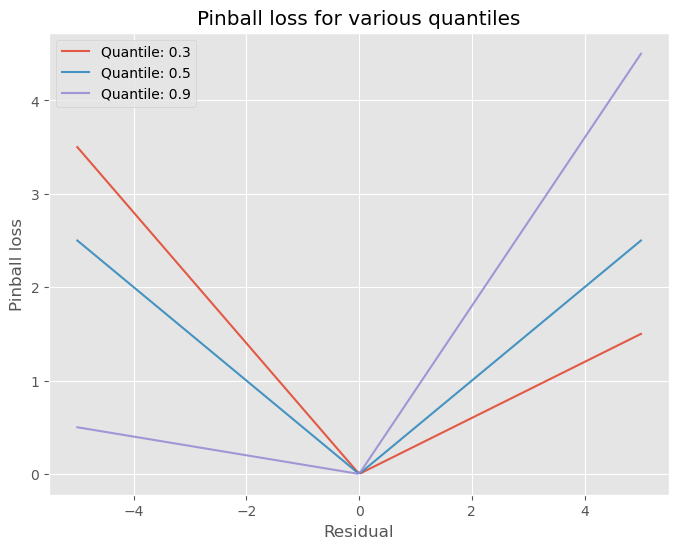

To fit quantile regression models in practice, Gradient Boosting Machines (GBM) are a natural candidate. Instead of using a squared error loss, as is usual, one just uses the appropriate pinball loss. These options are available in Scikit-learn implementations such as the `GradientBoostingRegressor` and `HistGradientBoostingRegressor` as will be shown later.

As stated earlier, a potentially simple scheme for estimating prediction intervals arises almost naturally here: by estimating two conditional quantiles, a lower bound, $q_L$ ,and an upper bound $q_U$. 

The quantile levels $(L, U): L \in [0; 1], U \in [0; 1], L < U$ to estimate are then chosen to achieve a certain _coverage_ $(1 - \alpha)$ and _mis-coverage_ levels ($\alpha$). Some examples:

* __A 90% symmetric prediction interval:__
    * mis-coverage is 10%:  $\alpha = 0.1$ 
    * coverage is 90%: $1 - \alpha = 0.9$
    * estimate conditional quantiles: $q_{0.05}(\mathbf{x})$ and $q_{0.95}(\mathbf{x})$, because miscoverage is distributed equally over lower and upper bounds
* __A 80% symmetric prediction interval:__
    * mis-coverage is 20%: , $\alpha = 0.2$ 
    * coverage is 80%: $1 - \alpha = 0.8$
    * estimate conditional quantiles for quantiles: $q_{0.1}(\mathbf{x})$ and $q_{0.9}(\mathbf{x})$
* __A 90% asymmetric prediction interval:__
    * mis-coverage is 10%:, $\alpha = 0.1$.
    * coverage is 90%:  $1 - \alpha = 0.9$
    * dsitribute mis-coverage for the lower and upper bound arises as desired, some examples:
        * 2.5% mis-coverage for the lower bound, 7.5% for the upper bound: estimate conditional quantile models for $q_{0.025}(\mathbf{x})$ and $q_{0.925}(\mathbf{x})$
        * 8% mis-coverage for the lower bound, 2% for the upper bound: estimate conditional quantile models for $q_{0.08}(\mathbf{x})$ and $q_{0.98}(\mathbf{x})$.


We could just stop here, because, estimating models by the appropriate pinball losses already guarantees convergence (statistical consistency) to the population conditional quantiles, ... at least asymptotically $(n \to +\infty)$ so. In finite samples, it has been shown that the actual coverage is far off from the required (nominal) coverage. 

However, Conformalized conditional Quantile Regression (CQR), will take the main idea from quantile regression and augment it. Note that for a more scientific exposition on the matter, see Romano et al. (2019) (https://arxiv.org/abs/1905.03222).

## Conformity Score

One of the most pivotal concepts in conformal prediction is the __conformity score $s_i$__. This score serves to encode (measure) the disagreement between predictions and targets. Many options exist on what kind of functional form of conformity score to choose. It can be something as simple as the absolute residual. However, since we are dealing with two conditional quantile regression models here, we need to apply some additional trickery.

Suppose you have chosen two $\tau$-values, a lower and upper value $(L, U)$ (e.g. $L=0.05$ and $U=0.95$) for your two predicted conditional quantiles $\hat{q}_L(\mathbf{x}), \hat{q}_U(\mathbf{x})$ to construct a prediction interval. 

One elegant option that works well for this case is the following conformity score which can be calculated for each observation $i=1, ..., n$

$$s_i(y_i, \hat{q}(\mathbf{x}_i)) = \max\{\hat{q}_L(\mathbf{x}_i) - y ~;~ y - \hat{q}_U(\mathbf{x}_i)\}$$

In essence: for observations where $y_i$ falls within the prediction interval range, both values are negative and the distance to the closest boundary is taken as conformity score, this will be the 'least negative' score and would make the resulting prediction bounds to move inwards (closer to each other). For observations outside the prediction interval, the value taken is the largest positive value and leads to the bounds moving outwards. In case the observation falls exactly on either of the bounds, the conformity score is exactly 0. The following figure provides examples for 6 different potantial situations.

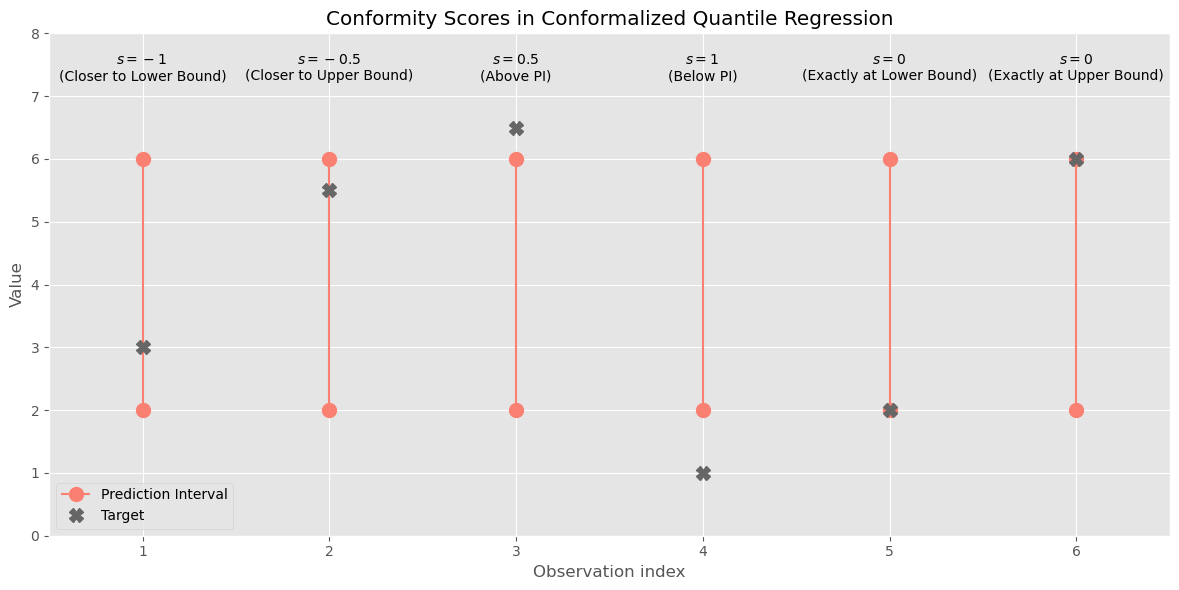

At this point we have $n$ conformity scores $s_i$, or a vector $\mathbf{s}$. What to do with these? The idea is simple: __from this vector of $s_i$, take the (1 - $\alpha$)'th quantile and use this as a correction factor to adjust the predicted lower and upper conditional quantiles.__

$$s_{adj, raw} = Quantile(s_1, ..., s_n; (1-\alpha))$$

We denote this as $s_{adj, raw}$, because usually a small-sample modification to the quantile picked from $s_i$ is proposed, this leads to $s_{adj}$
 
$$s_{adj} = Quantile(s_1, ..., s_n; (\frac{ceiling[(n + 1)(1-\alpha)]}{n}))$$

Note that for very large $n$, this adjusted value asymptotically will converge to the unadjusted (ordinary) sample quantile from the first formula.

Then, one simple thing needs to be done: adjust the resulting prediction interval using this calculated $s_{adj}$ to get the conformalized prediction interval $C(\mathbf{x}_i)$:


$$C(\mathbf{x}_i) = \left[ \hat{q}_{L}(\mathbf{x}_i) - s_{adj} ~ ; ~ \hat{q}_{U}(\mathbf{x}_i) + s_{adj} \right]$$

Let's elaborate a bit more why this last step will make the resulting prediction interval attain the requested $(1-\alpha)$ coverage level: assume that we are dealing with undercoverage, and let's take an example, we want a coverage ($1-\alpha = 0.9$), hence miscoverage is $\alpha=0.1$, but actually 20% of our target is falling 'outside' of the prediction interval, either above or below. Then, for 20% of the observations we will have positive scores, i.e. the 20% biggest $s_i > 0$, the rest will be negative. Equivalently: $Quantile(\mathbf{s}; 0.8) = 0$. __Hence taking the $(1-\alpha) = 0.9$ quantile (or small sample correction of it) will be a positive value, i.e. $s_{adj} > 0$, widening the prediction intervals.__

Even more so, the resulting $s_{adj}$ is exactly so that we adjust the prediction interval enough to have 90% of the observations exactly in it. This can be confirmed easily: take the 'conformalized' prediction interval (i.e. the one adjusted with $s_{adj}$) and calculate the $s_i$ scores _again_ and take the $(1-\alpha)$'th quantile, it should be zero now! Hence meaning: your prediction interval has attained correct coverage, no adjustment is needed!

Below a visualization of the distribution of $s_i$ taken from the _Ames_ housing data example from later in this post.

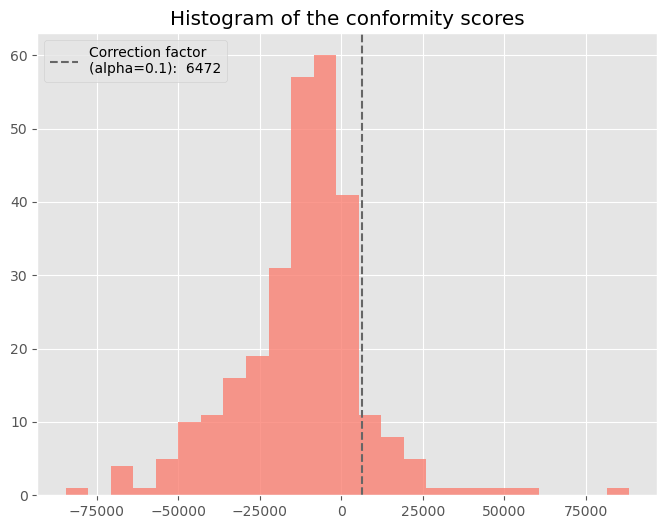

## Marginal and Conditional Coverage

One important aspect of coverage that we haven't, well..., _covered_, properly is that -until now- we have looked at coverage as a global property and not a local one. Indeed, the conformal correction applied does consider the conformity scores over the all observations (and hence range of the features $\mathbf{X}$) at once, and the correction factor $s_{adj}$ is applied on both the lower and upper bounds everywhere. It does not add any _additional_ "variablity" or adaptiveness in the width that wasn't created by the original quantile regression bounds. In other words: the conformalization steps done here only give (approximate) __marginal coverage guarantees__ and __not__ and __conditional (local) coverage guarantees__. The latter is obviously a lot harder and it has been shown that no method can be constructed to attain perfect conditional coverage. 

## Data Splitting Strategies: Split-Conformal Learning and Cross-Conformal Learning

Very briefly, let's talk about some of the history of conformal learning. The original ideas were preoccupipied with getting prediction intervals for a single unseen observation, and involved re-computing the intervals for each new observation. This made the original use of this framework (_full conformal prediction_) underused, understandably. In come data splitting (or resampling) strategies: very similarly to how data is often split to measure generalization performance (e.g. for hyperparameter tuning), one can also choose to split data to conformalize or calibrate a models' predictions, this leads to two new ways of working with conformal prediction:

1. Split-Conformal prediction
2. Cross-Conformal prediction

Split conformal prediction divides all available data into two disjoint sets:
* $D_1$: data used for training, the proper training set to train a machine learning model on
* $D_2$: data used for conformalizing or calibrating the trained machine learning model to achieve proper coverage

Cross-conformal learning will divide the dataset into $K$ disjoint groups, and similarly to cross-validation, will have one of the groups play the role of the calibration set, while the others together form the proper training set and repeat this $K$ times until each datapoint has been part of the calibration set exactly once and $K-1$ times member of the proper training set. 

The reason why we apply data splitting in the first place is very similar to why measuring loss on the training set might be misleading: we don't want optimistically bias the conformity scores $s_i$ and hence the resulting adjustment factor. Such a bias would lead to worse results on unseen data, i.e. having incorrect coverages on unseen data.

## Exchangeability Condition

At the start of this post, we stated that the very light distributional assumptions make conformal prediction an extremely valuable tool. However, there is one assumption that needs to hold: __exchangeability__. Exchangeability is a slightly weaker assumption than the more common independent and identifcally distributed (i.i.d.) assumption which is more well-known. Without going into much detail (it can get quite theoretical): any data with serial correction such as time series data generally violates the exchangeability condition. Cross-sectional data does adhere the condition more often but not always, e.g. in practice one often observes shifting distributions (covariate shift) which does invalidate the exchangeability condition. However, more recently, there are developments in making conformal prediction work (at least approximately) under various less-strict conditions. See e.g. Barber et al (2022) [(https://www.stat.berkeley.edu/~ryantibs/papers/nexcp.pdf)](https://www.stat.berkeley.edu/~ryantibs/papers/nexcp.pdf). 

We will assume the exchangeability condition holds from this point on for simplicity sake.

# Conformal Quantile Regression in Python

Let's now see how we can use conformal quantile regression in Python. First we will load libraries and the _Ames Housing_ data and perform some basic preprocessing on it.

## Loading Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore") # TODO VW: REMOVE THIS BLOCK -- SUCCESFULLY REMOVES RUNTIMEWARNINGS

We will load some the functions and classes necessary and set some additional parameters.

In [2]:
# Loading libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.datasets import fetch_openml
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_pinball_loss

# For reproduceability, showing which sklearn version is used. Use a modern version ideally >= 1.2
import sklearn; print(f"Scikit-learn version used: {sklearn.__version__}")

# Setting seed
seed = 42

# Setting plotting style
plt.style.use("ggplot")  # Cleaner plotting

Scikit-learn version used: 1.3.0


## Loading Data

We can load the _Ames_ housing dataset using the `fetch_openml` function. The Ames housing dataset contains 1460 rows of housing data with 80 features spanning characteristics like the construction year, living area size and amount of bedrooms amongst others. The target variable is the selling price in USD, we will use this dataset to create (correct) prediction intervals for this selling price.

In [3]:
# Loading Ames housing data
housing = fetch_openml(name="house_prices", 
                       as_frame=True, 
                       parser='auto')

# Getting features (X) and target (y)
X = housing['data']
y = housing['target']

print(f"X (feature matrix) shape: {X.shape}")
print(f"y (target vector) shape: {y.shape}")

X (feature matrix) shape: (1460, 80)
y (target vector) shape: (1460,)


## Basic Preprocessing

Before progressing, we will take a quick peek at the distribution of the target variable (the house selling price). Obviously, the distribution has a long right tail. One option could be to take the logarithm of the target and to proceed that way, but because this complicates interpretation ('log dollars' and all...), we will bypass the issue of very large outliers by cheating a bit and removing the rows for the top 2% of the targer variable. Note that the conformal prediction can deal with outliers just fine, but you need to be sure that they are equally spread over the splits of your data, and the latter can be the culprit sometimes.

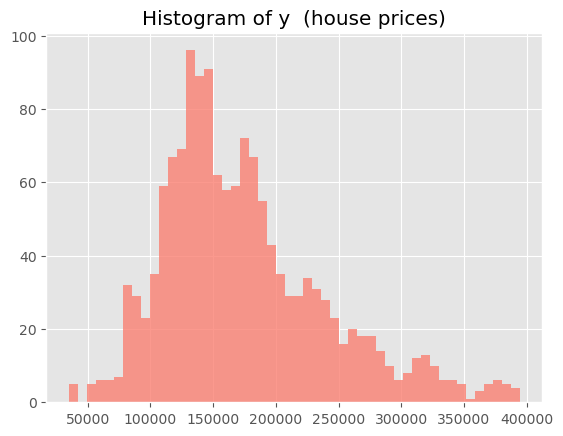

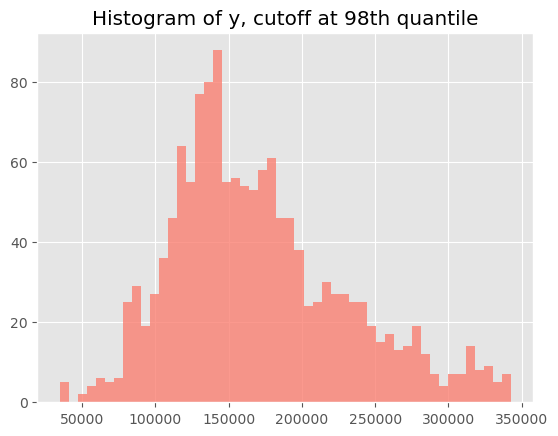

In [61]:
# Quick look, appearantly, extremely skewed:
plt.hist(y, bins=50, color='salmon', alpha=0.8);
plt.title('Histogram of y  (house prices)')
plt.show();

# Cutting off the very largest outliers
q_cutoff = 0.98
y_cutoff = np.quantile(a=y, q=q_cutoff)
plt.hist(y[y <= y_cutoff], bins=50, color='salmon', alpha=0.8);
plt.title(f"Histogram of y, cutoff at{q_cutoff*100: .0f}th quantile")
plt.show()

In [5]:
# Decision: let's cutoff at a certain quantile to avoid some outlier issues
remove_y_outliers = True
if remove_y_outliers:
    to_keep_idx = np.where(housing['target'] <= np.quantile(housing['target'], q_cutoff))
    y = housing['target'].loc[to_keep_idx]
    X = housing['data'].loc[to_keep_idx]

To further simplify matters, we will retain a more limited set of features (19) instead of 80, for ease of this tutorial, we only keep those that are continuous and don't have any missing values.

In [46]:
# Selecting some (mainly numeric) columns only
feat_cols = ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 
             'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 
             'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 
             'LowQualFinSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr',
             'TotRmsAbvGrd', 'GarageArea', 'WoodDeckSF']
X = X[feat_cols].copy()

Let's split the data into 3 parts for now in a 60-20-20 split.
* $D_1$: the _proper training set_ used for training the model. This part will be also divided into parts using cross-validation for tuning hyperparameters. (60% of the observations)
* $D_2$: the _calibration set_ used to conformalize the prediction intervals. (50% of 40% = 20% of observations)
* $D_3$: a completely unseen test set that can be used to see if the coverages hold in unseen data. (50% of 40% = 20% of observations)

In [7]:
# Splitting in train-calibration-test set
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=seed)
X_cal, X_test, y_cal, y_test = train_test_split(X_rest, y_rest, test_size=0.5, shuffle=True, random_state=seed)

print(f"Train set n: {len(y_train)} ({len(y_train)/len(y)*100:.0f}%)")
print(f"Calibration set n: {len(y_cal)} ({len(y_cal)/len(y)*100:.0f}%)")
print(f"Test set n: {len(y_test)} ({len(y_test)/len(y)*100:.0f}%)")

Train set n: 858 (60%)
Calibration set n: 286 (20%)
Test set n: 286 (20%)


## Training and Tuning Conditional Quantile Regression GBMs

Let's use a very general approach for training and tuning GBM models, with the main differences being:
* Choosing a coverage level $1 - \alpha$, and choosing how to allocate the mis-coverage over the lower and upper boundaries. (Or more generally: pick a lower and upper bound for your prediction intervals). We will choose a symmetric 90% prediction interval, hence: $q_L = q_{0.05}$ and $q_U = q_{0.95}$.
* Training and tuning of the two conditional quantile models instead of a single (conditional mean) model.
* Use of the appropriate pinball losses, both for training and tuning. 

Except this, the procedure we will follow is quite common:

1. Defining a hyperparameter grid. We'll take some basic hyperparameters and define reasonable values for them. We will use the same grid for both conditional quantiles we estimate.
2. Define scoring metrics (appropriate pinball loss) for each model using `make_scorer()`, for conditional mean models you'd usually just use default scoring.
3. Instantiate a GBM for each quantile to estimate. We will use the newer `HistGradientBoostingRegressor` that takes inspiration from XGBoost and LightGBM implementations, in recent versions this supports estimation of quantiles by defining `loss='quantile'` and supplying the requested $\tau$ to the `quantile` argument.
4. Define a data splitting strategy, for this we will use a repeated K-fold cross-validation setup using the built-in `RepeatedKFold` class. We'll use 2-times repeated 4-fold cross-validation by means of `RepeatedKFold`.
5. Search the hyperparameter grid by sampling using random search (`RandomizedSearchCV`), we will only search 10 values, for simplicity sake.
6. Extract the optimal parameters and associatd models from the calculations to make predictions with.

In [8]:
# Generating hyperparameter grid
param_grid = {'learning_rate': [0.01, 0.1, 0.2, 0.5, 1, 2, 5, 10],
              'max_iter': [50, 100, 150, 250],  # amount of trees
              'max_depth': [2, 3, 5, 7],
              'min_samples_leaf': [3, 5, 10, 20, 30]}        

# Defining mis-coverage level alpha
alpha = 0.10

# Defining tau to predict the quantile q_tau for
taus = [0.05, 0.95]  # contains (L, U) levels

# Setting some other CV params
n_hyperparams = 20
n_folds = 4
n_repeats = 2
seed = 42

# Create the appropriate pinball loss functions
pinball_losses = [make_scorer(mean_pinball_loss, alpha=tau, greater_is_better=False) for tau in taus]
pinball_losses = dict(zip(taus, pinball_losses))  # Dictionary with the alphas as keys and losses as values

# Cross-validation with chosen search strategy for hyperparameter values
models = dict.fromkeys(taus, None)  # Dictionary with keys being the tau values to save models in
tuning_objects = dict.fromkeys(taus, None)  # Same, but to save tuned model in

# For each requested conditional quantile level
for tau in taus:
    print(f'Tuning hyperparameters for conditional quantile regression model: q_{tau}')
    models[tau] = HistGradientBoostingRegressor(loss='quantile', quantile=tau, random_state=seed) 
    # Alternatively use GradientBoostingRegressor
    
    # Repeated K-fold cross-validation data resampling strategy
    cv = RepeatedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=seed)
    
    # Tuning using random grid search
    tuning_objects[tau] = RandomizedSearchCV(estimator=models[tau],
                                             cv=cv,
                                             param_distributions=param_grid,
                                             n_iter=n_hyperparams,
                                             scoring=pinball_losses[tau],
                                             random_state=seed,
                                             verbose=1)
    tuning_objects[tau].fit(X=X_train, y=y_train)
    print(f'Optimal hyperparameters {tuning_objects[tau].best_params_}')
    print('*' * 125)

Tuning hyperparameters for conditional quantile regression model: q_0.05
Fitting 8 folds for each of 20 candidates, totalling 160 fits
Optimal hyperparameters {'min_samples_leaf': 30, 'max_iter': 150, 'max_depth': 2, 'learning_rate': 0.2}
*****************************************************************************************************************************
Tuning hyperparameters for conditional quantile regression model: q_0.95
Fitting 8 folds for each of 20 candidates, totalling 160 fits
Optimal hyperparameters {'min_samples_leaf': 30, 'max_iter': 150, 'max_depth': 2, 'learning_rate': 0.2}
*****************************************************************************************************************************


Let's now use the optimally (re)-trained models for the lower and upper quantiles and predict instances on the (unseen) calibration data.

In [9]:
# Gather predictions on calibration data, putting them in a N x 2 NumPy array
preds_cal_lower = tuning_objects[taus[0]].predict(X=X_cal)
preds_cal_upper = tuning_objects[taus[1]].predict(X=X_cal)
preds_cal = np.column_stack([preds_cal_lower, preds_cal_upper])

# Gather predictions on test data, putting them in a N x 2 NumPy array
preds_test_lower = tuning_objects[taus[0]].predict(X=X_test)
preds_test_upper = tuning_objects[taus[1]].predict(X=X_test)
preds_test = np.column_stack([preds_test_lower, preds_test_upper])

## Conformalizing the Quantile Regression Model

We take the predictions on the calibration dataset ($D_2$) and translate the theory into code. For this we will make a small function `calculate_conformal_correction`.

In [20]:
def calculate_conformal_correction(preds_cal, target_cal, alpha):
    """
    Calculates conformity scores and calculates the modified quantile to correct the raw prediction intervals
    provided to achieve correct requested coverage and mis-coverage (alpha). Ideally this is performed on a 
    separate calibration dataset (hence pred_cal, target_cal).
    
    Parameters:
    - preds_cal: 2 x n Numpy array with predictions
    - target_cal: Target values in NumPy array (or Pandas Series)
    - alpha: Float denoting miscoverage level
    
    Returns:
    - Conformal correction (float) to apply on lower and upper bounds.
    """
    # Calculate the 'deviations' from lower and upper predicted quantiles
    preds_lower = preds_cal[:, 0]  # First col is lower bound
    preds_upper = preds_cal[:, 1]  # Second col is upper bound
    dev = np.column_stack([preds_lower - target_cal, target_cal - preds_upper])
    conf_scores = np.max(dev, axis=1)  # max of each 2-pair of deviations: i=1, ..., N
    
    # Take the 'modified' quantile of these conformity scores 
    n = len(target_cal)
    alpha_compl_mod = np.ceil((n + 1) * (1 - alpha)) / n
    correction = np.quantile(a=conf_scores, q=alpha_compl_mod)
    
    return correction

# Use function to calculate the correction factor
conformal_correction = calculate_conformal_correction(preds_cal=preds_cal,
                                                      target_cal=y_cal,
                                                      alpha=0.1)
print(f"The conformal correction calculated on the calibration data is: {conformal_correction: .2f} (USD)")

# Compare the correction magnitude to average of target in calibration set to get relative idea
print(f"The conformal correction relative to the average house price: {conformal_correction / y_cal.mean() * 100:.2f}%")

The conformal correction calculated on the calibration data is:  6472.27 (USD)
The conformal correction relative to the average house price: 3.67%


The calculated correction factor to adjust both lower and upper (raw) prediction bounds is (+) 6472 (USD). This is approximately 3.67% of the average house, hence nothing dramatic. This seems very reasonable compared to the magnitude of house prices. Do note that this is added to the existing width of the prediction intervals created by the two conditional quantile regression models; we will see that the sum-total of both actually is, rather large!

We can now progress by just applying the adjustment, since it's positive it means that we will enlarge the prediction interval, hence moving the lower bound down and the upper bound up. 

In [12]:
# Conformalize the calibration and test predictions using the calculated correction
preds_cal_lower_conf = preds_cal_lower - conformal_correction
preds_cal_upper_conf = preds_cal_upper + conformal_correction
preds_cal_conf = np.column_stack([preds_cal_lower_conf, preds_cal_upper_conf])

preds_test_lower_conf = preds_test_lower - conformal_correction
preds_test_upper_conf = preds_test_upper + conformal_correction
preds_test_conf = np.column_stack([preds_test_lower_conf, preds_test_upper_conf])

## Confirming Coverage

Let's now check, on the unseen test data set, if the requested coverage is achieved. We make a very simple function `calculate_coverage` to do so.

In [13]:
def calculate_coverage(preds, target):
    """
    Calculates if the target falls within the lower and upper bounds to calculate actual coverage.
    
    Parameters:
    - preds: 2 x n NumPy array with predictions
    - target: Numpy array with target
    
    Returns:
    - Float (between 0 and 1) denoting the coverage level of the PI.
    """
    # Count observations where target is within bounds (1 if yes, 0 if not)
    target_in_bounds_indicator = np.where((preds[:, 0] <= target) & (preds[:, 1] > target), 1, 0)
    
    # Return average (=proportion with the 0/1 from above)
    return np.mean(target_in_bounds_indicator)

# Use the function defined above
coverage_test_raw = calculate_coverage(preds=preds_test, target=y_test)
coverage_test_conformal = calculate_coverage(preds=preds_test_conf, target=y_test)

print(f"** Requested coverage levels: {1 - alpha: .2f} **")
print(f"Actual coverage on test set without conformal correction: {coverage_test_raw: .2f}")
print(f"Actual coverage on test set with conformal correction: {coverage_test_conformal: .2f}")

** Requested coverage levels:  0.90 **
Actual coverage on test set without conformal correction:  0.79
Actual coverage on test set with conformal correction:  0.89


We see that, using the correction calculated on the separate calibration set, also leads to getting nearer to requested coverage on unseen data. We can also performan a sanity check that on the calibration set itself, the correction achieves (near) perfect coverage.

In [14]:
# Sanity check: coverage on the calibration set itself should be near perfect
coverage_cal_raw = calculate_coverage(preds=preds_cal, target=y_cal)
coverage_cal_conformal = calculate_coverage(preds=preds_cal_conf, target=y_cal)

print(f"** Requested coverage levels: {1 - alpha: .2f} **")
print(f"Actual coverage on calibration set without conformal correction: {coverage_cal_raw: .2f}")
print(f"Actual coverage on calibration set with conformal correction: {coverage_cal_conformal: .2f}")

** Requested coverage levels:  0.90 **
Actual coverage on calibration set without conformal correction:  0.80
Actual coverage on calibration set with conformal correction:  0.91


Yes it does work as expected: going from 80% coverage without conformalizing to 90% as was requested!

## Basic Properties of the Prediction Intervals

Next to the coverage, we can also check other properties of the prediction intervals. In the following code block, we create a function that takes the calibration predictions and targets as well as the test predictions and targets and prints the following summary statistics, for respectively the raw (uncalibrated) calibration predictions, the conformalized calibration predictions, the raw test predictions and finally the conformalized test predictions (where the latter is conformalized with the correction factor calculated on the calibration set, as it should be!):

* Average width of the prediction interval
* Average relative width: the average width divided by the average of the target value
* Median width: as additional information in case the average width would be impacted by a few very wide regions
* (Marginal) coverage

In [15]:
def calculate_conformal_diagnostics(preds_cal, preds_cal_conf, target_cal, preds_test, 
                                    preds_test_conf, target_test, return_df=False):
    """
    Creates an overview/diagnostics. First it calculates the conformal correction necessary using
    calculate_conformal_correction() on the calibration data (using the raw predictions and the actual target). 
    Then it both corrects the calibration predictions and supplied test predictions. Finally it calculates the 
    following statistics: (1) average width, (2) median width, (3) average relative width compared to the mean
    of the target
    
    In case of return_df=True, it also returns a Pandas DataFrame with all information.
    
    Parameters:
    - preds_cal: 2 x n NumPy array of predictions on calibration data
    - preds_cal_conf: 2 x n NumPy array of conformalized predictions on calibration data
    - target_cal: NumPy array with target variable from calibration data
    - pred_test:  2 x n NumPy array of predictions on unseen data
    - preds_test_conf: 2 x n NumPy array of conformalized predictions on unseen data
    - target_test: NumPy array with target variable from unseen data
    - return_df: Boolean denoting if diagnostics info should be returnedin overview DF
    
    Returns:
    - None if return_df = False, else return_df: overview diagnostics Pandas DF.
    """    
    # Coverage indicators per row
    coverage_cal_raw = calculate_coverage(preds=preds_cal, target=y_cal)
    coverage_cal_conf = calculate_coverage(preds=preds_cal_conf, target=y_cal)
    coverage_test_raw = calculate_coverage(preds=preds_test, target=y_test)
    coverage_test_conf = calculate_coverage(preds=preds_test_conf, target=y_test)
    
    # Calculating widths
    width_cal_raw = np.abs(preds_cal[:, 1] - preds_cal[:, 0])
    width_cal_conf = np.abs(preds_cal_conf[:, 1] - preds_cal_conf[:, 0]) 
    width_test_raw = np.abs(preds_test[:, 1] - preds_test[:, 0])
    width_test_conf = np.abs(preds_test_conf[:, 1] - preds_test_conf[:, 0])
    
    df = pd.DataFrame({
        'pred_cal_lower_raw': preds_cal[:, 0],
        'pred_cal_upper_raw': preds_cal[:, 1],
        'pred_cal_lower_conf': preds_cal_conf[:, 0],
        'pred_cal_upper_conf': preds_cal_conf[:, 1],
        'pred_test_lower_raw:': preds_test[:, 0],
        'pred_test_upper_raw': preds_test[:, 1],
        'pred_test_lower_conf': preds_test_conf[:, 0],
        'pred_test_upper_conf': preds_test_conf[:, 1],
        'coverage_cal_raw': coverage_cal_raw,
        'coverage_cal_conf': coverage_cal_conf,
        'coverage_test_raw': coverage_test_raw,
        'coverage_test_conf': coverage_test_conf,
        'width_cal_raw': width_cal_raw,
        'width_cal_conf': width_cal_conf,
        'width_test_raw': width_test_raw,
        'width_test_conf': width_test_conf
    })
    
    # Getting summary statistics of interesting quantities
    # Average width
    avg_width_cal_raw = df['width_cal_raw'].mean()
    avg_width_cal_conf = df['width_cal_conf'].mean()
    avg_width_test_raw = df['width_test_raw'].mean()
    avg_width_test_conf = df['width_test_conf'].mean()
    
    # Median width
    med_width_cal_raw = df['width_cal_raw'].median()
    med_width_cal_conf = df['width_cal_conf'].median()
    med_width_test_raw = df['width_test_raw'].median()
    med_width_test_conf = df['width_test_conf'].median()
    
    # Average relative width (= avg of width divided by respective target value)
    avg_rel_width_cal_raw = (df['width_cal_raw'] / target_cal).mean()
    avg_rel_width_cal_conf = (df['width_cal_conf'] / target_cal).mean()
    avg_rel_width_test_raw = (df['width_test_raw'] / target_test).mean()
    avg_rel_width_test_conf = (df['width_test_conf'] / target_test).mean()
    
    
    avg_rel_width_cal_raw = avg_width_cal_raw / np.mean(target_cal)
    avg_rel_width_cal_conf = avg_width_cal_conf / np.mean(target_cal)
    avg_rel_width_test_raw = avg_width_test_raw / np.mean(target_test)
    avg_rel_width_test_conf = avg_width_test_conf / np.mean(target_test)
    
    # Coverage
    coverage_cal_raw = df['coverage_cal_raw'].mean()
    coverage_cal_conf = df['coverage_cal_conf'].mean()
    coverage_test_raw = df['coverage_test_raw'].mean()
    coverage_test_conf = df['coverage_test_conf'].mean()
        
    # Average PI width
    print(f"Calibration set: raw average PI width: {avg_width_cal_raw: .0f}")
    print(f"Calibration set: conformalized average PI width: {avg_width_cal_conf: .0f}")
    print(f"Test set: raw average PI width: {avg_width_test_raw: .0f}")
    print(f"Test set: conformalized average PI width: {avg_width_test_conf: .0f}")
    print("*" * 125)
    
    # Average relative PI width (compared to the average of target)
    print(f"Calibration set: raw average relative PI width: {avg_rel_width_cal_raw: .2f}")
    print(f"Calibration set: conformalized average relative PI width: {avg_rel_width_cal_conf: .2f}")
    print(f"Test set: raw average relative PI width: {avg_rel_width_test_raw: .2f}")
    print(f"Test set: conformalized average relative PI width: {avg_rel_width_test_conf: .2f}")
    print('*' * 125)
    
    # Median PI width
    print(f"Calibration set: raw median PI width: {med_width_cal_raw: .0f}")
    print(f"Calibration set: conformalized median PI width: {med_width_cal_conf: .0f}")
    print(f"Test set: raw median PI width: {med_width_test_raw: .0f}")
    print(f"Test set: conformalized median PI width: {med_width_test_conf: .0f}")
    print("*" * 125)
    
    # Coverage
    print(f"Calibration set: raw coverage: {coverage_cal_raw: .2f}")
    print(f"Calibration set: conformalized coverage: {coverage_cal_conf: .2f}")
    print(f"Test set: raw coverage: {coverage_test_raw: .2f}")
    print(f"Test set: conformalized coverage: {coverage_test_conf: .2f}")
    
    if return_df:
        return df
    
# Let's use the function defined above
print(f"Conformal adjustment factor, calculated on the calibration data: ${conformal_correction: .2f}")
print(f"Requested coverage: {alpha: .2f}")
print("*" * 125)
calculate_conformal_diagnostics(preds_cal=preds_cal, 
                                preds_cal_conf=preds_cal_conf, 
                                target_cal=y_cal, 
                                preds_test=preds_test, 
                                preds_test_conf=preds_test_conf, 
                                target_test=y_test)

Conformal adjustment factor, calculated on the calibration data: $ 6472.27
Requested coverage:  0.10
*****************************************************************************************************************************
Calibration set: raw average PI width:  58079
Calibration set: conformalized average PI width:  70993
Test set: raw average PI width:  58017
Test set: conformalized average PI width:  70962
*****************************************************************************************************************************
Calibration set: raw average relative PI width:  0.33
Calibration set: conformalized average relative PI width:  0.40
Test set: raw average relative PI width:  0.34
Test set: conformalized average relative PI width:  0.41
*****************************************************************************************************************************
Calibration set: raw median PI width:  44533
Calibration set: conformalized median PI width:  57478
Test set:

Discussing some of the numbers printed above, focusing on the unseen data, which is the most honest to talk about:
* The average width of a non-conformalized interval was around USD 58K, the conformalized variant being 2 times the conformal correction factor wider (USD 79.1K)
* Relative to the selling price, the average width of the interval is around 34% of the selling price for the raw interval and around 41% for the conformalized interval. 
* There is a slight (marginal) undercoverage on the test data, we attain 89%, while having requested 90%, still this is close to our target!

## Visualization of Prediction Intervals

Let's try to get an intuitive visualization of what is happening by taking a selection of observations (e.g. 10) and plotting them with their associated raw prediction intervals straight from the conditional quantile regression and the conformalized equivalents.

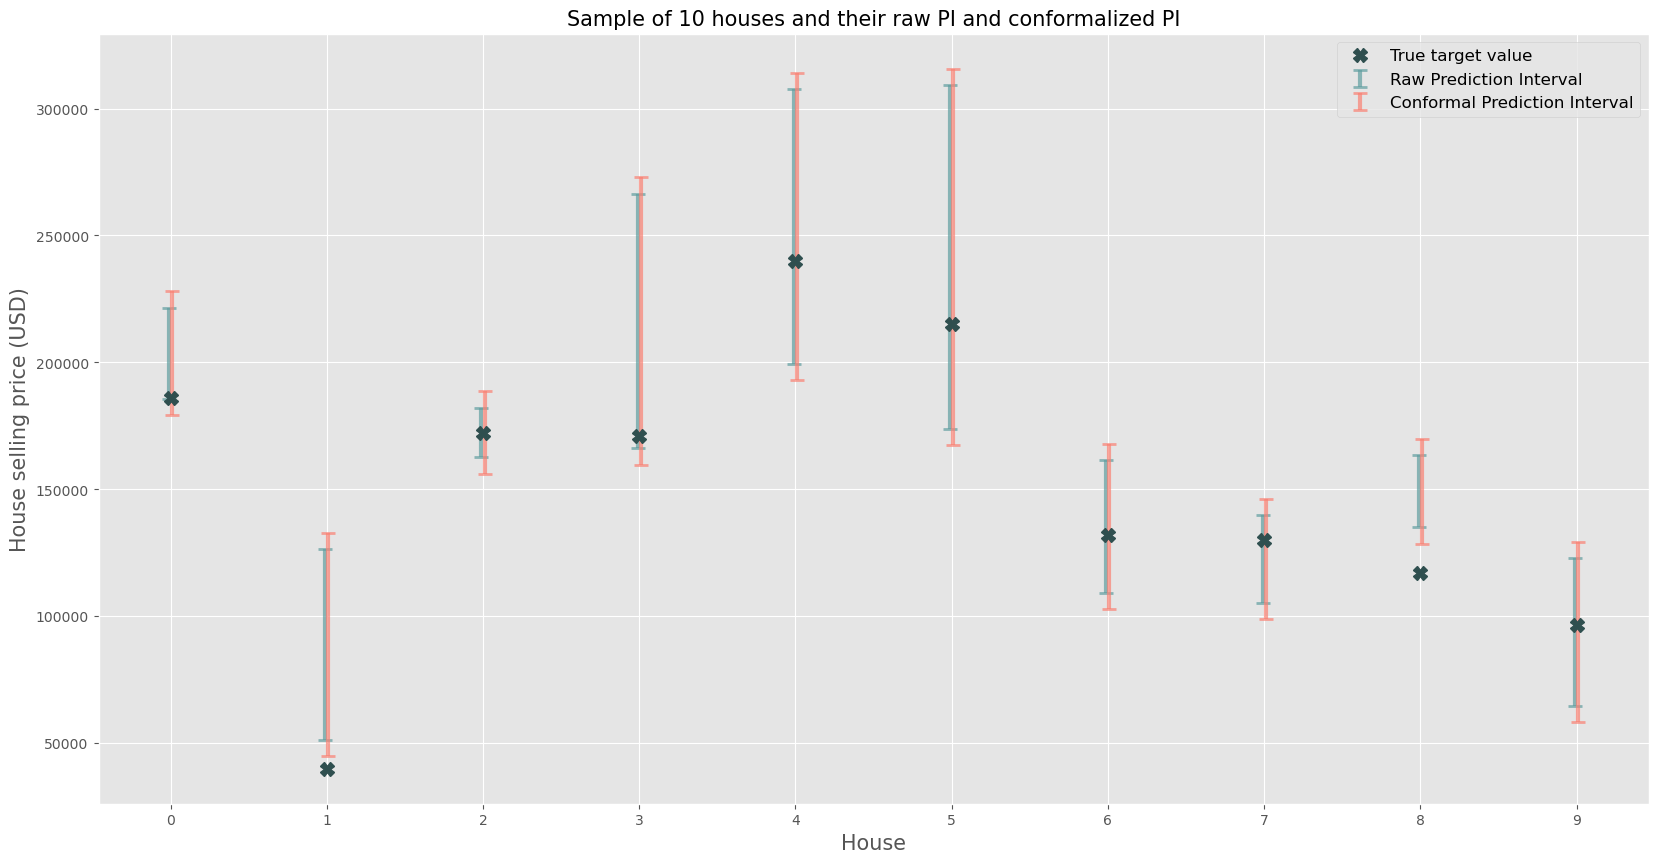

In [16]:
# Plotting sample of some observations
# Let's put everything in a DF first
df_to_plot = pd.DataFrame(data={
    'y_test': y_test,
    'preds_test_lower': preds_test_lower,
    'preds_test_upper': preds_test_upper,
    'preds_test_lower_conformal': preds_test_lower_conf,
    'preds_test_upper_conformal': preds_test_upper_conf
}, index=y_test.index)

# Then, sample some observations (10)
n_sample = 10
preds_test_sample = (df_to_plot.sample(n_sample, 
                                       random_state=seed)
                     .reset_index())  # reset_index, it makes plot cleaner

# Plotting
plt.figure(figsize=(20, 10))

# Plotting the PIs with vertical lines and whiskers
# For raw prediction intervals
plt.errorbar(x=preds_test_sample.index - 0.01, # small adjustment to not have the 2 bars overlap perfectly
             y=(preds_test_sample['preds_test_lower'] + preds_test_sample['preds_test_upper']) / 2,  # "midpoint of the PI"
             yerr=[(preds_test_sample['preds_test_upper'] - preds_test_sample['preds_test_lower']) / 2],  # half the width around the point
             fmt=' ', color='lightblue', ecolor='cadetblue', elinewidth=3, capsize=5, capthick=2, alpha=0.7,
             label='Raw Prediction Interval')

# For conformal prediction intervals
plt.errorbar(x=preds_test_sample.index + 0.01, # small adjustment to not have the 2 bars overlap perfectly
             y=(preds_test_sample['preds_test_lower_conformal'] + preds_test_sample['preds_test_upper_conformal']) / 2,  # "midpoint of the PI"
             yerr=[(preds_test_sample['preds_test_upper_conformal'] - preds_test_sample['preds_test_lower_conformal']) / 2],  # half the width around the point
             fmt=' ', color='lightcoral', ecolor='salmon', elinewidth=3, capsize=5, capthick=2, alpha=0.7,
             label='Conformal Prediction Interval')

# Plot true target values
plt.plot(preds_test_sample.index, preds_test_sample['y_test'], 'X', markersize=10, color='darkslategray', label='True target value')
plt.title(f"Sample of {n_sample} houses and their raw PI and conformalized PI", fontsize=15)
plt.xlabel('House', fontsize=15)
plt.xticks(np.arange(n_sample))
plt.ylabel('House selling price (USD)', fontsize=15)
plt.legend(fontsize=12)
plt.show()

This gives some additional insight for a random selection of 10 houses, note that for some houses the resulting prediction intervals are much wider than others (e.g. house 5 vs. house 2). Of course it's important to understand that some phenomena have higher intrinsic uncertainty than others, and the real estate market, being a market with a high degree of information asymmetry certainly falls victim to this.

# Class Implementation

To end the blogpost, we propose a class-based solution that makes heavy use of Scikit-learn methods and is inspired by its style in terms of implementation. The goal is to have a class `ConformalizedQuantileRegressorCV` that, with some easy method calling, performs the following steps:

1. Fit two requested quantile regression models that are provided and tunes its hyperparameters using random search cross-validation. 
2. Calculates the conformal correction factor using the `calculate_conformal_correction()` method. In first instance, the methods laid out earlier can be used (this is basically a 'symmetric' CQR method). However, it can also account for asymmetric cases and for cases where the requested prediction interval bounds and the estimated conditional quantile regression models don't exactly match.
3. Using `predict_conformal()` it will take the conformal correction factors and conformalize the prediction bounds.

The code for the class is provided below and an example on how to use it.

In [42]:
import numpy as np
import pandas as pd
import logging

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.base import clone
from sklearn.metrics import mean_pinball_loss
from sklearn.metrics import make_scorer

class ConformalizedQuantileRegressorCV:
    """
    Scikit-learn-inspired Conformalized (Conditional) Quantile Regression CQR for making
    valid interval predictions using the split-conformal method. This class contains
    multiple methods for conformalizing the predictions and has hyperparameter tuning
    support. The idea here is to request which lower and upper quantiles should be estimated.
    Later, when executing the predict_conformal() method; one can either choose to conformalize
    using those lower and upper quantiles that were requested, or to request other lower and upper bounds. (e.g.
    estimating quantiles (0.05 ; 0.95) but wanting valid PI of e.g. (0.10 ; 0.90), if the user requires.
    
    Parameters:
    - estimator: The base machine learning estimator supporting quantile regression (sklearn object!)
    - quantiles: A list of floats, indicating the quantiles to be estimated.
    - param_distributions: Dictionary with hyperparameters names as keys and their values.
    - n_iter: Number of parameter settings that are sampled in the randomized search.
    - cv: data splitting strategy, can be integer or e.g. KFold object.
    - random_state: Seed used by the random number generator.
    """
    def __init__(self, estimator, quantiles, param_distributions, n_iter, cv, random_state=42):
        self.estimator = estimator
        self.quantiles = quantiles
        self.param_distributions = param_distributions
        self.n_iter = n_iter
        self.cv = cv  # cv it either a number or a CV object!
        self.random_state = random_state
        
        self.conformal_correction = None
        
    def fit(self, X, y):
        """
        Loops over the different conditional quantiles to estimate and perform a randomized hyperparameter search 
        tuning procedure for the requested `param_distributions`, requested `n_iter` amount of candidate hyperparameter
        combination values and cross-validation (`cv`) scheme. 
        
        The search is optimized using input data X (features) and y (univariate target).
        
        Best estimators themselves, best parameters, cv results and scores are saved.
        
        Parameters:
        - X: Features array.
        - y: Target array.
        """
        # Check if "quantile" parameter name either "quantile" or "alpha"
        if "quantile" in self.estimator.get_params():
            self.q_param_name = "quantile"  # e.g. HistGradientBoostingRegressor
        elif "alpha" in self.estimator.get_params():
            self.q_param_name = "alpha"  # e.g. GradientBoostingRegressor
        
        # Loop over all to-estimate quantiles
        self.estimators_ = []
        for q in self.quantiles: 
            # Clone for each requested quantile level (for the correct param name)
            est = clone(self.estimator).set_params(**{self.q_param_name: q})
            
            # Generate associated pinball loss at quantile for CV scoring
            scorer = make_scorer(mean_pinball_loss, alpha=q, greater_is_better=False)
            
            # Instantiate + compute random search CV
            tuning = RandomizedSearchCV(estimator=est,
                                        param_distributions=self.param_distributions,
                                        n_iter=self.n_iter,
                                        cv=self.cv,
                                        scoring=scorer,
                                        refit=True,  # fit final model on all folds
                                        random_state=self.random_state)
            tuning.fit(X=X, y=y)
            
            # Appending to calculated (_) estimators
            self.estimators_.append(tuning)  # contains tuning objects!
            
        # Saving some attributes from the tuning objects (that are stored in self.estimators_ now)
        self.best_estimator_ = [t.best_estimator_ for t in self.estimators_]
        self.best_params_ = [t.best_estimator_.get_params() for t in self.estimators_]
        # .get_params() on the best_estimator_ works better than .best_params_ because it will return 
        # all available parameters (contrary to best_params_) even if they are optimally at default values
        # and knowing that defaults can change over sklearn versions...
        self.cv_results_ = [t.cv_results_ for t in self.estimators_]
        self.best_score_ = [t.best_score_ for t in self.estimators_]
        
        return self
                  
    def predict(self, X):
        """
        Returns (2 x N) Numpy array of predictions for the optimal model found by means of
        cross-validation.
        
        Parameters:
        - X: Features array in NumPy style
        
        Returns:
        - A 2D array of shape (n_samples, 2) with lower and upper predictions.
        """
        if self.estimators_ is not None:        
            preds = [est.predict(X=X)[:, np.newaxis] for est in self.best_estimator_]
            # Note: CV objects when calling .predict() on them will predict on fitted versions trained on all X
            #  data (as long as refit=True (as is default)).
        else:
            logging.error('Run predict only after calling models have been fitted, call the fit() method!')
            
        return np.hstack(preds)
    
    def find_closest_quantile_models(self, lower=None, upper=None):
        """
        Helper method that checks if the requested prediction intervals match up with any of the estimated
        quantile models, if not it takes the closest. Puts the results in self.model_lower and self.model_upper!
        """        
        # If no specific lower and upper bound is given: just take the (min, max) of requested q levels
        if lower is None:
            lower = min(self.quantiles)
            # By definition, it will find an exact match in the next block of logic
                     
        if upper is None:
            upper = max(self.quantiles)
            # By definition, it will find an exact match in the next block of logic

        ## Quantile level matcher / closest match logic - LOWER
        # If exact match available -> pick that one
        if lower in self.quantiles:
            self.model_lower = [x for x in self.best_estimator_ if x.get_params()[self.q_param_name] == lower][0]
            lower_closest = self.model_lower.get_params()[self.q_param_name]   # saving which estimated quantile is closest
            self.lower_mismatch = 0  # No mismatch on the requested PI boundaries and estimated CQR models
        
        # If not: find lower (closest) estimated quantile model
        else:
            # Find closest match
            lower_closest = min(self.quantiles, key=lambda x: abs(x - lower)) # lower closest quantile
            self.lower_mismatch = min([abs(x - lower) for x in self.quantiles])  # Save mismatch
            logging.info(f"Mismatch ({self.lower_mismatch:.3f}) on estimated quantile and requested lower PI bound")
            self.model_lower = [x for x in self.best_estimator_ if x.get_params()[self.q_param_name] == lower_closest][0]    

        ## Quantile level matcher / closest match logic - UPPER
        # If exact match available -> pick that one
        if upper in self.quantiles:
            self.model_upper = [x for x in self.best_estimator_ if x.get_params()[self.q_param_name] == upper][0]
            upper_closest = self.model_upper.get_params()[self.q_param_name]  # saving which estimated quantile is closest
            self.upper_mismatch = 0  # No mismatch on the requested PI boundaries and estimated CQR models
            
        else:
            # Find closest match
            upper_closest = min(self.quantiles, key=lambda x: abs(x - upper))
            self.upper_mismatch = min([abs(x - upper) for x in self.quantiles])  # Save mismatch
            logging.info(f"Mismatch ({self.upper_mismatch:.3f}) on estimated quantile and requested upper PI bound")
            self.model_upper = [x for x in self.best_estimator_ if x.get_params()[self.q_param_name] == upper_closest][0]
            
        # Check if lower < upper
        if upper_closest < lower_closest:
            logging.warning("Mismatch on requested quantile models, tried finding closest match but lower model match has higher quantile level than higher match")
        
        # Saving results as attributes
        self.lower_match = lower_closest 
        self.upper_match = upper_closest
        
    def infer_alpha_levels(self, lower, upper):
        """
        If symmetry is not forced, this method will check if the requested (lower, upper) bounds
        AND the requested quantile models mismatch are symmetric. If so, it will revert to the
        symmetric setup, else, it will set a self.alpha_low and self.alpha_high instead of 
        self.alpha alone. Also sets self.symmetric appropriately.
        """
        if (abs((1 - upper) - lower) < 1e-5) & (abs(self.lower_mismatch - self.upper_mismatch) < 2e-2):
            self.symmetric = True
            self.alpha = lower + (1 - upper)
            self.alpha_low = None
            self.alpha_high = None
        else:
            logging.warning(f"Using asymmetric formula, either due to request or or due to differing mismatch on underlying CQR models...")
            self.symmetric = False
            self.alpha_low = lower
            self.alpha_high = 1 - upper
            self.alpha = None
        
    def calculate_conformal_correction(self, X_cal, y_cal, lower, upper, symmetric=None):
        """
        Calculates the conformal correction. The interface is a bit special: a lower and upper bound
        are to be provided to the function. If you want a 90% symmetric PI: provide lower=0.05, upper=0.95.
        By default, the function will try to find the closest (already) predicted quantiles in the model and use 
        those predictions to apply the conformalization on.
        
        A dataset to calculate the conformalization correction should be provided (X_cal, y_cal), ideally this 
        is unseen data.
        
        Parameters:
        - X_cal: Calibration features array.
        - y_cal: Calibration target array.
        - lower: Desired lower bound for prediction interval.
        - upper: Desired upper bound for prediction interval.
        - symmetric: Whether to enforce symmetric intervals. If None, determines symmetry based on mismatches.
        
        """
        # Setting this attribute
        self.symmetric = symmetric # will be overwritten if None
        
        # Fetch closest estimated quantile model to the requested PI bounds
        self.find_closest_quantile_models(lower=lower, upper=upper)        
        # -> results will be stored in self.lower_match; self.upper_match!

        # Deviate only from symmetry when specifically asked because symmetry is more efficient
        if not symmetric:
            self.infer_alpha_levels(lower=lower, upper=upper)
                
        # Obtain (raw) predictions for lower and upper CQR models on calibration data
        preds_lower = self.model_lower.predict(X=X_cal)
        preds_upper = self.model_upper.predict(X=X_cal)

        ## CALCULATING CONFORMAL CORRECTION - CQR
        # Gather distances from lower, upper bound
        lower_conf_scores = preds_lower - y_cal
        upper_conf_scores = y_cal - preds_upper
        
        # Adjust quantile level slightly to give better approximation
        if self.symmetric:
            # For each observation: take maximum of both distances
            conf_scores = np.column_stack((lower_conf_scores, upper_conf_scores)).max(axis=1)
            adj_alpha_compl = (1 - self.alpha) * (1 + 1 / len(y_cal))
            
            # Just 2 duplicate cols for constant output interface!
            self.conformal_corr = np.column_stack([np.quantile(a=conf_scores, q=adj_alpha_compl),
                                                   np.quantile(a=conf_scores, q=adj_alpha_compl)])
        # Asymmetric will lead to better coverage, but will be wider!
        else:
            adj_alpha_low_compl = (1 - self.alpha_low) * (1 + 1 / len(y_cal))
            adj_alpha_high_compl = (1 - self.alpha_high) * (1 + 1 / len(y_cal))
            self.conformal_corr = np.column_stack([np.quantile(a=lower_conf_scores, q=adj_alpha_low_compl),
                                                   np.quantile(a=upper_conf_scores, q=adj_alpha_high_compl)])
            
    def predict_conformal(self, X):        
        """Takes the calculated conformal correction (shift) factor and applies them to the raw predictions"""
                
        if self.conformal_corr is None:
            logger.error("Conformal correction not calculated yet, apply the calculate_conformal_correction method")
                    
        # Get raw predictions and correct
        conformal_preds_lower = self.model_lower.predict(X=X) - self.conformal_corr[:, 0]
        conformal_preds_upper = self.model_upper.predict(X=X) + self.conformal_corr[:, 1]
        conformal_preds = np.column_stack([conformal_preds_lower, conformal_preds_upper])
        
        return conformal_preds

The class takes an Scikit-learn estimator as input in the `estimator` argument for instantiation. The class is tested on the `HistGradientBoostingRegressor` and `GradientBoostingRegressor` classes, any model should work as long as it uses `quantile` or `alpha` as an argument to denote its to-estimate quantile level (and no other param overlaps in these 2 names!).

Further it takes a list of to-estimate quantile levels for the base models in the `quantiles` argument, ideally these match up with the bounds of the prediction interval that are wanted, but this is not a strict requirement. 

The `param_distributions` is a hyperparameter grid that is passed to the `RandomizedSearchCV` class used in this implementation. Provide valid hyperparameters and candidate values in the typical dictionary format.

Finally, `n_iter` Denotes the amount of hyperparameter value candidates to search over and `cv` can be an integer denoting the amount of folds, or a more complex Scikit-learn data splitter can be provided like `KFold` or `RepeatedKFold`.

After instantiating the class, provide the training dataset ($D_1$) to the `fit()` method, which will train + tune the model and pick the optimal model based on the best pinball loss values. Then, calculate the conformal correction necessary using the `calculate_conformal_correction()` on the calibration data ($D_2$), finally get the conformalized predictions using `predict.conformal()`.

In [18]:
# Using the class implementation
# Setting some parameters w.r.t. PI and quantiles
lower = 0.05  # PI lower bound
upper = 0.95  # PI upper bound
q_lower = 0.05  # Lower conditional quantile to estimate
q_upper = 0.95  # Upper conditional quantile to estimate

# Define the estimator that has a "quantile" argument
quantile_gbm = HistGradientBoostingRegressor(loss="quantile",  # Make sure to set quantile loss!
                                             random_state=seed)

# Define a hyperparameter grid
param_grid = {'learning_rate': [0.01, 0.1, 0.2, 0.5, 1, 2, 5, 10],
              'max_iter': [50, 100, 150, 250],  # amount of trees
              'max_depth': [2, 3, 5, 7],
              'min_samples_leaf': [3, 5, 10, 20, 30]}
n_hyperparam_sample = 20
n_folds = 5

# Instantiate the class
cqr_cv = ConformalizedQuantileRegressorCV(estimator=quantile_gbm,
                                          quantiles=[q_lower, q_upper], 
                                          param_distributions=param_grid, 
                                          n_iter=n_hyperparam_sample, 
                                          cv=n_folds)

# Fit on the training set (D_1)
cqr_cv.fit(X=X_train, y=y_train)

# Calculating conformal correction
cqr_cv.calculate_conformal_correction(X_cal=X_cal, y_cal=y_cal, lower=lower, upper=upper)

# Getting raw and conformalized predictions
preds_cal2 = cqr_cv.predict(X=X_cal)
preds_cal_conf2 = cqr_cv.predict_conformal(X=X_cal)
preds_test2 = cqr_cv.predict(X=X_test)
preds_test_conf2 = cqr_cv.predict_conformal(X=X_test)

Let's check and confirm if the attained coverage matches the requested coverage, as well as some other summary statistics, like before.

In [19]:
# Using the diagnostics function
requested_coverage =  upper - lower
print(f"****Requested coverage: {requested_coverage:.2f}****")
print("*" * 125)
calculate_conformal_diagnostics(preds_cal=preds_cal2,
                                preds_cal_conf=preds_cal_conf2, 
                                target_cal=y_cal, 
                                preds_test=preds_test2, 
                                preds_test_conf=preds_test_conf2, 
                                target_test=y_test)

****Requested coverage: 0.90****
*****************************************************************************************************************************
Calibration set: raw average PI width:  58079
Calibration set: conformalized average PI width:  70413
Test set: raw average PI width:  58017
Test set: conformalized average PI width:  70382
*****************************************************************************************************************************
Calibration set: raw average relative PI width:  0.33
Calibration set: conformalized average relative PI width:  0.40
Test set: raw average relative PI width:  0.34
Test set: conformalized average relative PI width:  0.41
*****************************************************************************************************************************
Calibration set: raw median PI width:  44533
Calibration set: conformalized median PI width:  56898
Test set: raw median PI width:  46182
Test set: conformalized median PI width

Indeed, the calibration on the unseen dataset now has improved from 79% to 88%, which is a lot closer to the requested 90% coverage!

# Next up

This gives an idea about the basics of conformalized quantile regression. Extensions surely exist and I have some more advanced implementations that I might share in a next post. Stay tuned!

# Sources
* Romano, Patterson & Candes (2019): Conformalized Quantile Regression [(https://arxiv.org/abs/1905.03222)](https://arxiv.org/abs/1905.03222)
* Barber et al. (2022): Conformal prediction beyond exchangeability [(https://www.stat.berkeley.edu/~ryantibs/papers/nexcp.pdf)](https://www.stat.berkeley.edu/~ryantibs/papers/nexcp.pdf)
* Valemans _Awesome Conformal Prediction_ GitHub page [(https://github.com/valeman/awesome-conformal-prediction)](https://github.com/valeman/awesome-conformal-prediction)

# Extra Code and Figure Code

Figures for which we don't want to provide code. DON'T INCLUDE IN BLOGPOST

## Pinball Loss Figure

In [48]:
# Pinball loss
def calculate_pinball_loss(resid, tau):
    loss = np.where(resid >= 0, tau * resid, -1 * (1 - tau) * resid)
    return loss

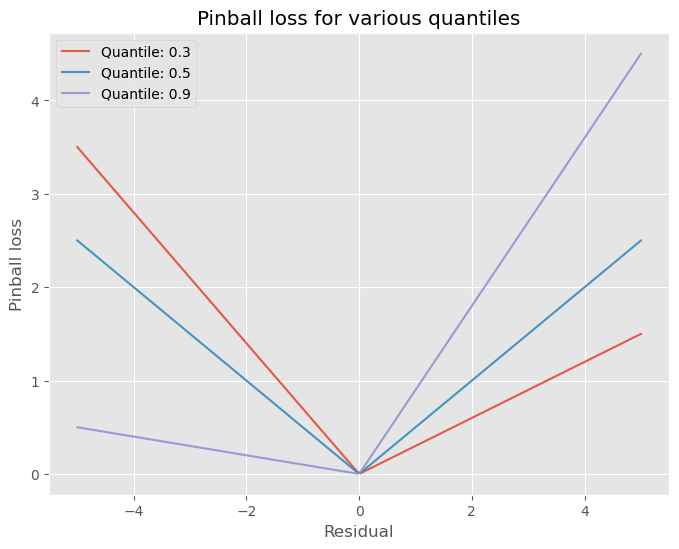

In [50]:
# Generate some hypothetical residuals (target - pred)
resid = np.linspace(start=-5, stop=5, num=200)

# Plot for selection of tau values
plt.figure(figsize=(8, 6))
for tau in [0.3, 0.5, 0.9]:
    pinball_loss = calculate_pinball_loss(resid=resid, tau=tau)
    plt.plot(resid, pinball_loss, alpha=0.9, label=f"Quantile: {tau}");
    plt.legend();
    plt.title("Pinball loss for various quantiles")
    plt.ylabel("Pinball loss");
    plt.xlabel("Residual");

## Conformity Score Figure

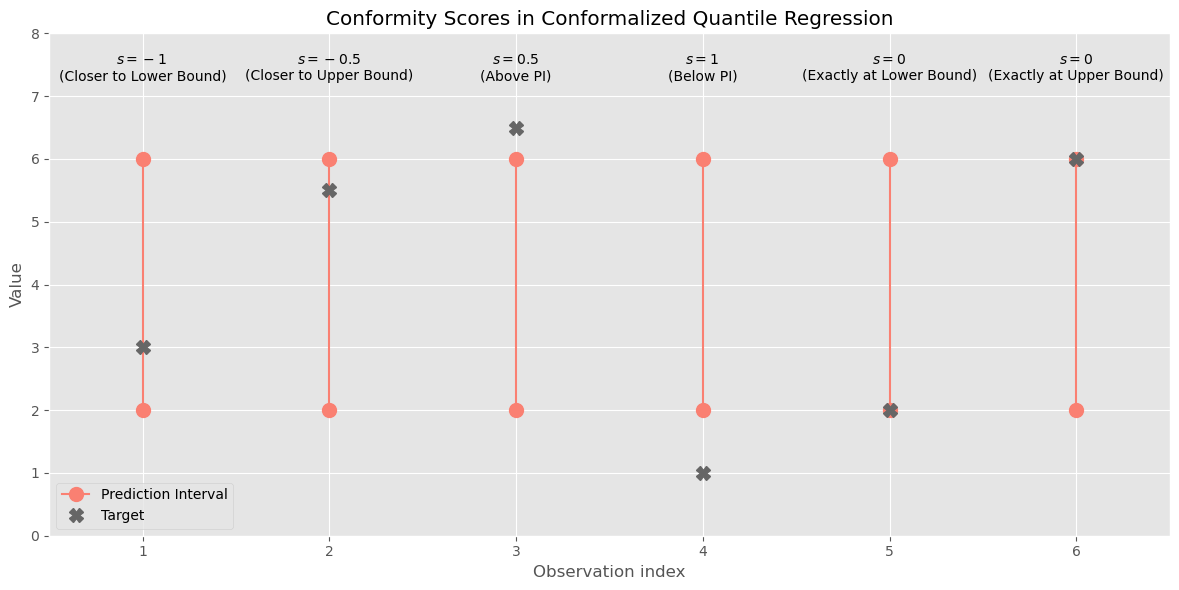

In [51]:
# Conformity score plot
plt.style.use('ggplot')
import matplotlib.ticker as ticker

# Define the positions for the five scenarios now
positions = np.arange(1, 7)
# Define the prediction intervals for each scenario, note the adjustment for the split first scenario
lower_bounds = [2] * 6
upper_bounds = [6] * 6
targets = [3, 5.5, 6.5, 1, 2, 6]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each scenario
for pos, lower, upper, target in zip(positions, lower_bounds, upper_bounds, targets):
    # Plot the prediction interval
    ax.plot([pos, pos], [lower, upper], '-o', color="salmon", markersize=10, 
            label='Prediction Interval' if pos == 1 else "")
    # Plot the target
    ax.plot(pos, target, 'X', color='0.40', markersize=10, 
            label='Target' if pos == 1 else "")  
    # Way to not plot 'target' many times in legend!

# Add annotations to describe each scenario
annotations = ['$s=-1$ \n(Closer to Lower Bound)', 
               '$s=-0.5$ \n(Closer to Upper Bound)', 
               '$s=0.5$ \n(Above PI)', 
               '$s=1$ \n(Below PI)', 
               '$s=0$ \n(Exactly at Lower Bound)',
               '$s=0$ \n(Exactly at Upper Bound)']
for pos, annotation in zip(positions, annotations):
    ax.text(x=pos, y=upper_bounds[0] + 1.25, s=annotation, horizontalalignment='center', fontsize=10)

# Setting the plot
ax.set_xlim(0.5, 6.5)
ax.set_ylim(0, 8)
ax.set_xticks(positions)
ax.set_xlabel('Observation index')
ax.set_ylabel('Value')
ax.set_title('Conformity Scores in Conformalized Quantile Regression')
ax.legend(loc='lower left')
plt.tight_layout()
plt.show()

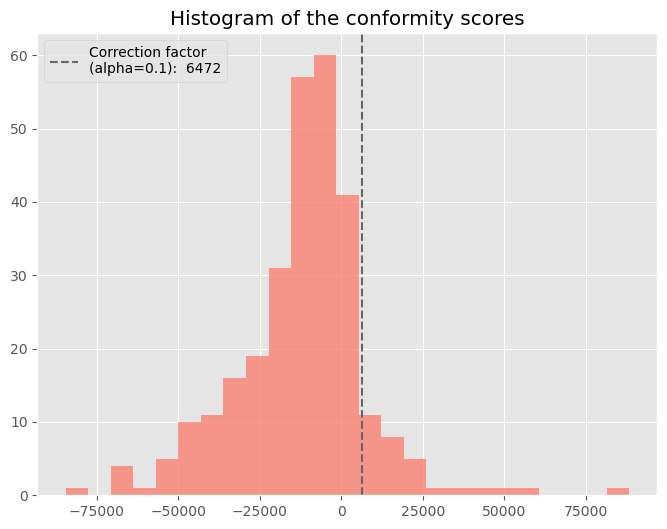

In [52]:
# Histogram of conformity scores
preds_lower = preds_cal[:, 0]  # First col is lower bound
preds_upper = preds_cal[:, 1]  # Second col is upper bound
dev = np.column_stack([preds_lower - y_cal, y_cal - preds_upper])
conf_scores = np.max(dev, axis=1)  # max of each 2-pair of deviations: i=1, ..., N
n = len(conf_scores)
alpha_compl_mod = np.ceil((n + 1) * (1 - alpha)) / n
s_adj = np.quantile(a=conf_scores, q=alpha_compl_mod)

plt.figure(figsize=(8, 6));
plt.hist(x=conf_scores, bins=25, density=False, color='salmon', alpha=0.8);
plt.axvline(x=s_adj, linestyle="--", color='0.40', label=f"Correction factor \n({alpha=}): {s_adj: .0f}");
plt.title('Histogram of the conformity scores')
plt.legend(loc="upper left");

## Blogpost Figure Code 

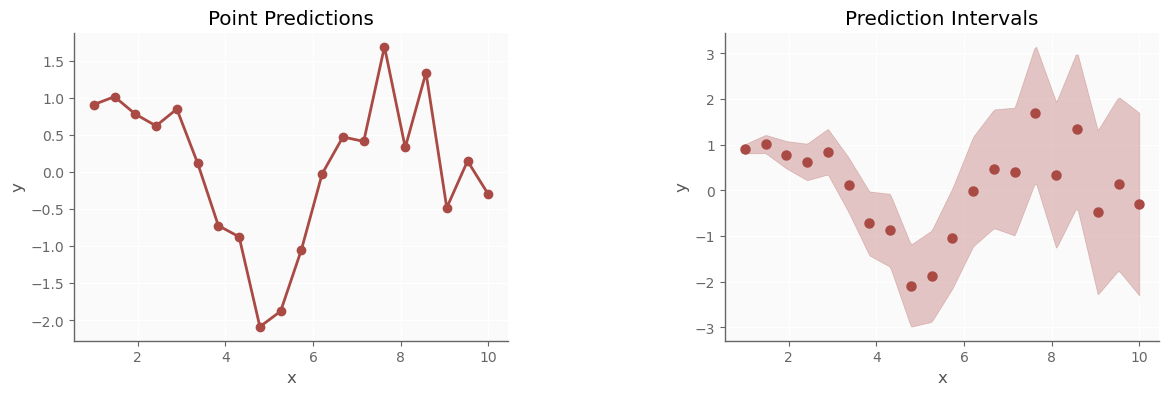

In [74]:
# Simulate more data points for the point predictions and more variable prediction intervals
x_points = np.linspace(1, 10, 20)  # More x-points
y_points = np.sin(x_points) + np.random.normal(0, 0.1, len(x_points)) * x_points  # More y-points with variability

# Simulate data for prediction intervals with varying widths
x_interval = np.linspace(1, 10, 200)
y_interval_mean = np.interp(x_interval, x_points, y_points)
intervals = np.linspace(0.1, 2, len(x_interval))  # Varying intervals
y_upper = y_interval_mean + intervals
y_lower = y_interval_mean - intervals

# Define a stylish color for 2023/2024
point_color = "#AA4A44"  # Brick red color

# Create wider space between subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 4), gridspec_kw={'wspace': 0.5})

# Configure the subplots for a modern theme
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#666666')
    ax.spines['bottom'].set_color('#666666')
    ax.tick_params(axis='x', colors='#666666')
    ax.tick_params(axis='y', colors='#666666')
    ax.set_facecolor('#FAFAFA')

# Plot point predictions
axs[0].plot(x_points, y_points, marker='o', linestyle='-', color=point_color, lw=2)
axs[0].set_title('Point Predictions')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Plot prediction intervals with varying widths
axs[1].scatter(x_points, y_points, color=point_color, lw=1.5)
axs[1].fill_between(x_interval, y_lower, y_upper, color=point_color, alpha=0.3)
axs[1].set_title('Prediction Intervals')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


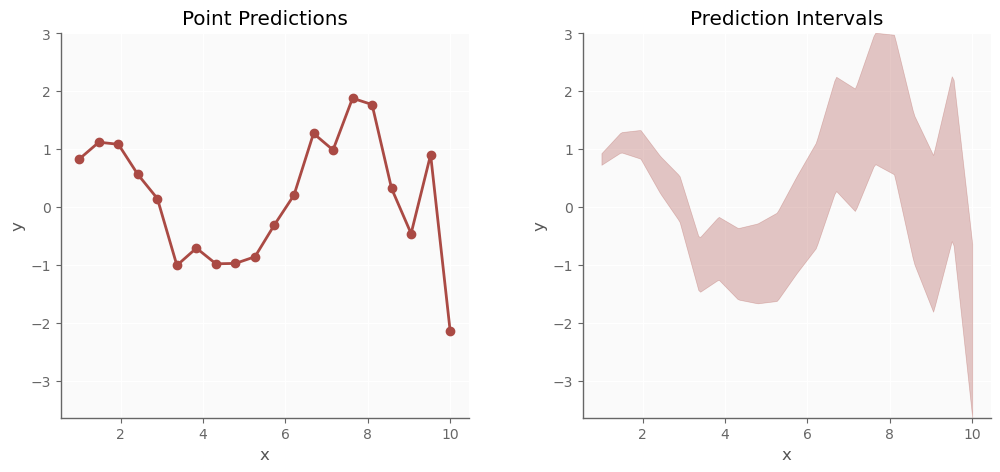

In [84]:
# Adjust the color to be more brick brown reddish
point_color = "#8B4513"  # A shade closer to brick brown/red

# Simulate more data points for the point predictions and more variable prediction intervals
x_points = np.linspace(1, 10, 20)  # More x-points
y_points = np.sin(x_points) + np.random.normal(0, 0.1, len(x_points)) * x_points  # More y-points with variability

point_color = "#AA4A44"  # Brick red color
# Simulate data for prediction intervals with varying widths
x_interval = np.linspace(1, 10, 200)
y_interval_mean = np.interp(x_interval, x_points, y_points)
intervals = np.linspace(0.1, 1.5, len(x_interval))  # Varying intervals
y_upper = y_interval_mean + intervals
y_lower = y_interval_mean - intervals

# Determine common y-limits based on the generated data
common_ylim = (min(y_lower), max(y_upper))

# Create wider space between subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'wspace': 0.28})

# Configure the subplots for a modern theme
for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#666666')
    ax.spines['bottom'].set_color('#666666')
    ax.tick_params(axis='x', colors='#666666')
    ax.tick_params(axis='y', colors='#666666')
    ax.set_facecolor('#FAFAFA')
    ax.set_ylim(common_ylim)  # Apply common y-limits to both subplots

# Plot point predictions
axs[0].plot(x_points, y_points, marker='o', linestyle='-', color=point_color, lw=2)
axs[0].set_title('Point Predictions')
axs[0].set_xlabel('x')
axs[0].set_ylabel('y')

# Plot prediction intervals with varying widths
axs[1].fill_between(x_interval, y_lower, y_upper, color=point_color, alpha=0.3)
axs[1].set_title('Prediction Intervals')
axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots